In [98]:
def trim_start_end_nans(df):
    """
    Removes rows at the start and end of a DataFrame that have NaN values in any column.
    """
    # Initialize start_idx and end_idx based on the DataFrame's index type
    if isinstance(df.index, pd.DatetimeIndex):
        start_idx = df.index[0]  # Assume first index is earliest; adjust if necessary
        end_idx = df.index[-1]  # Assume last index is latest; adjust if necessary
    else:
        start_idx = 0
        end_idx = len(df) - 1

    for column in df.columns:
        # Find the first non-NaN index in the current column
        first_valid_index = df[column].first_valid_index()
        if first_valid_index is not None and df.index.get_loc(first_valid_index) > df.index.get_loc(start_idx):
            start_idx = first_valid_index

        # Find the last non-NaN index in the current column
        last_valid_index = df[column].last_valid_index()
        if last_valid_index is not None and df.index.get_loc(last_valid_index) < df.index.get_loc(end_idx):
            end_idx = last_valid_index

    # Trim the DataFrame
    return df.loc[start_idx:end_idx]

# Now, apply the updated function to the DataFrame



                     Unnamed: 0  Ta_2m_Avg  RH_2m_Avg  Solar_2m_Avg  \
TIMESTAMP                                                             
2023-07-31 01:00:00       557.0  28.566000  71.488000     16.378667   
2023-07-31 02:00:00       549.0  26.562000  80.442333      0.000000   
2023-07-31 03:00:00       501.0  25.184333  85.723333      0.000000   
2023-07-31 04:00:00       493.0  24.316167  88.250000      0.000000   
2023-07-31 05:00:00       494.0  23.755500  89.378333      0.000000   

                     WndAveSpd_3m  Rain_1m_Tot  Dp_2m_Avg   TaMax_2m  \
TIMESTAMP                                                              
2023-07-31 01:00:00      1.954283          0.0  22.891500  28.706667   
2023-07-31 02:00:00      1.581950          0.0  22.917833  26.711500   
2023-07-31 03:00:00      2.321450          0.0  22.623833  25.318333   
2023-07-31 04:00:00      1.875700          0.0  22.249667  24.465000   
2023-07-31 05:00:00      2.809600          0.0  21.902167  23.897500  

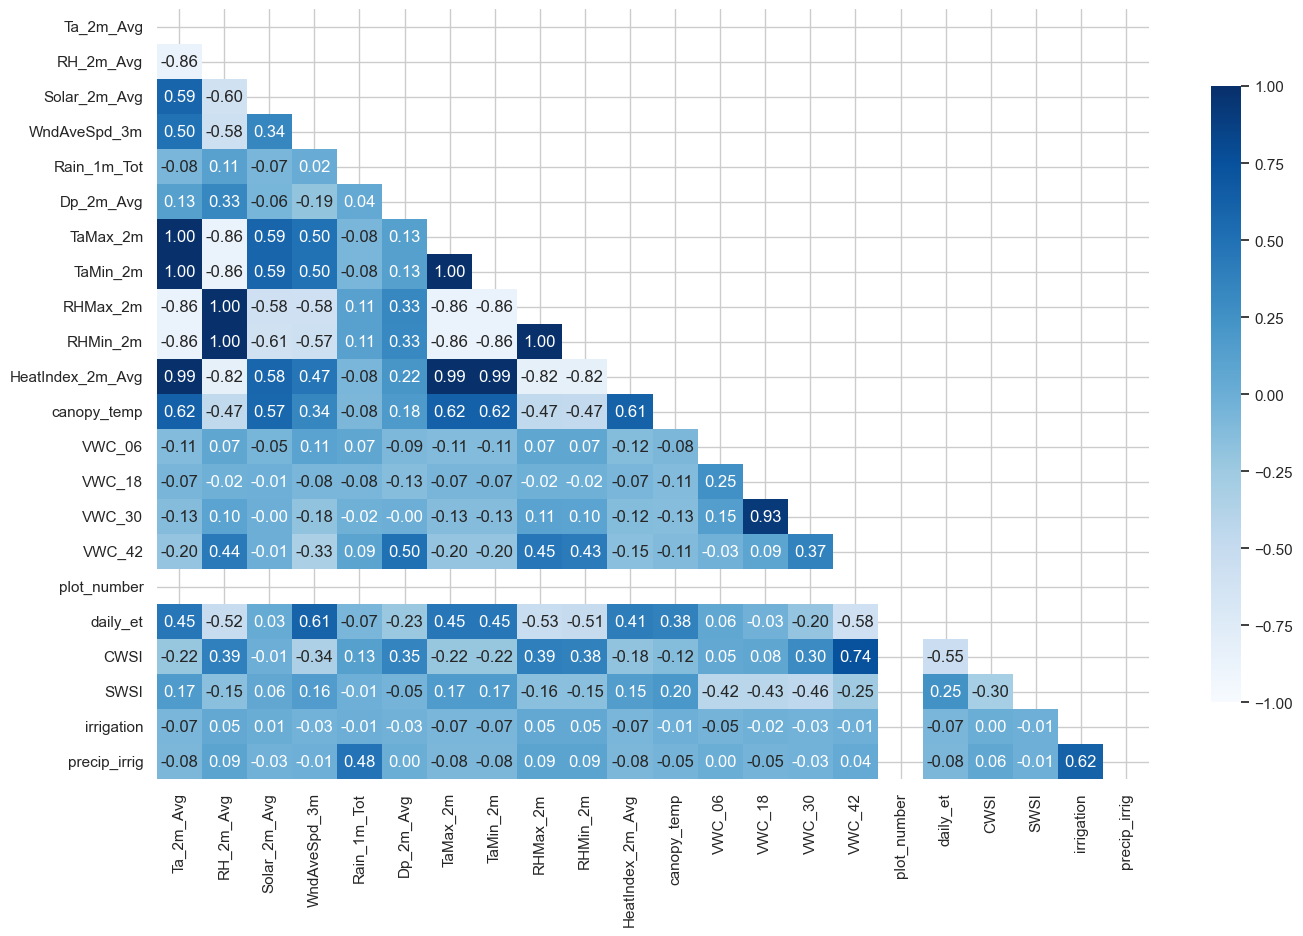

In [99]:
# Imports for data handling, processing, and visualization
import sqlite3
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Connect to the database and load data
conn = sqlite3.connect('processed_data.db')
query = 'SELECT * from data_table'
df = pd.read_sql_query(query, conn)
conn.close()

# Select plot_number 2014
df = df[df['plot_number'] == 2014]

# Select data between July 19 and September 06
df = df[(df['TIMESTAMP'] >= '2023-07-20') & (df['TIMESTAMP'] <= '2023-09-03')]

#store timestamp for later use
df_timestamp = pd.to_datetime(df['TIMESTAMP'])

#


# Timestamp cyclical encoding
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df['day_sin'] = np.sin(df['TIMESTAMP'].dt.dayofyear / 365 * 2 * np.pi)
df['day_cos'] = np.cos(df['TIMESTAMP'].dt.dayofyear / 365 * 2 * np.pi)
df['hour_sin'] = np.sin(df['TIMESTAMP'].dt.hour / 24 * 2 * np.pi)
df['hour_cos'] = np.cos(df['TIMESTAMP'].dt.hour / 24 * 2 * np.pi)
df['dow_sin'] = np.sin(df['TIMESTAMP'].dt.dayofweek / 7 * 2 * np.pi)
df['dow_cos'] = np.cos(df['TIMESTAMP'].dt.dayofweek / 7 * 2 * np.pi)

time_columns = ['day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']


target_columns = ['VWC_06', 'VWC_18', 'VWC_30', 'VWC_42']  # Adjust column names if necessary

# Select columns for correlation matrix
corr_columns = [
    'Ta_2m_Avg', 'RH_2m_Avg', 'Solar_2m_Avg', 'WndAveSpd_3m', 'Rain_1m_Tot', 
    'Dp_2m_Avg', 'TaMax_2m', 'TaMin_2m', 'RHMax_2m', 'RHMin_2m', 'HeatIndex_2m_Avg', 'canopy_temp', 'VWC_06', 'VWC_18', 
    'VWC_30', 'VWC_42', 'plot_number', 'daily_et', 'CWSI', 'SWSI', 'irrigation', 'precip_irrig'
]

# Elimunate duplicate indices by keeping the first occurrence
df = df[~df.index.duplicated(keep='first')]

# Set timestamp as index
df = df.set_index('TIMESTAMP')
df.sort_index(inplace=True)

# trim start and end nans
df= trim_start_end_nans(df)

print(df.head())

# interpolate missing values
df = df[corr_columns + time_columns]
df = df.interpolate(method='pchip')
# df = df.interpolate(method='akima')





# Normalization (if beneficial after exploration)
#scaler = MinMaxScaler()
#df[target_columns] = scaler.fit_transform(df[target_columns])



# Visualization setup
sns.set(style='whitegrid', palette='muted', font_scale=1)
plt.figure(figsize=(16, 10))



exog_columns = time_columns + corr_columns

# Ensure the DataFrame contains only the columns of interest for the correlation matrix
df_corr = df[corr_columns].corr()

# Create mask for upper triangle
mask = np.triu(np.ones_like(df_corr, dtype=bool))

# Plot heatmap
sns.heatmap(df_corr, mask=mask, annot=True, fmt=".2f", cmap='Blues',
            vmin=-1, vmax=1, cbar_kws={"shrink": .8})

# Show plot
plt.show()


In [100]:
import pandas as pd
import plotly.graph_objs as go
import numpy as np


def plot_data(*args, title='Forecast vs Actuals', xlabel='Time', ylabel='Value', labels=None):
    """
    Plots multiple time series data on a single graph.

    Args:
        *args: Variable length argument list of time series data. Each argument can be either a pandas Series or DataFrame.
        title (str): Title of the plot (default: 'Forecast vs Actuals').
        xlabel (str): Label for the x-axis (default: 'Time').
        ylabel (str): Label for the y-axis (default: 'Value').
        labels (list): List of labels for each time series (default: None).

    Raises:
        ValueError: If the length of labels does not match the number of time series provided.

    Returns:
        None
    """
    
    # Initialize a figure from Plotly
    fig = go.Figure()

    # Check if labels list is provided and has the correct length
    if labels and len(labels) != len(args):
        raise ValueError("Length of labels must match the number of time series provided.")

    for i, arg in enumerate(args):
        # If arg is a Series, convert to DataFrame with TIMESTAMP as a column
        if isinstance(arg, pd.Series):
            df = arg.to_frame(name='value')
            df['TIMESTAMP'] = df.index
        # If arg is a DataFrame, ensure TIMESTAMP is a column
        elif isinstance(arg, pd.DataFrame):
            df = arg.reset_index()
        
        # Check and adjust the timezone of TIMESTAMP
        if df['TIMESTAMP'].dt.tz is None:
            df['TIMESTAMP'] = df['TIMESTAMP'].dt.tz_localize('UTC')
        if df['TIMESTAMP'].dt.tz != 'US/Central':
            df['TIMESTAMP'] = df['TIMESTAMP'].dt.tz_convert('US/Central')

        # Generate and add trace for each series
        trace = go.Scatter(
            x=df['TIMESTAMP'],
            y=df['value'] if isinstance(arg, pd.Series) else df[df.columns[1]], # Use 'value' for Series, or the first data column for DataFrame
            mode='lines',
            name=labels[i] if labels else 'Series {}'.format(i)
        )
        fig.add_trace(trace)

    # Update layout with provided labels and title
    fig.update_layout(
        title=title,
        xaxis_title=xlabel,
        yaxis_title=ylabel,
        margin=dict(l=50, r=50, t=50, b=50),
        font=dict(size=12),
    )
    # Show plot
    fig.write_html(f'title.html', auto_open=True)


#plot_data(df["VWC_06"], title='VWC_06', labels=["VWC_06"])



import pandas as pd
from pmdarima.arima.utils import ndiffs, diff
from pmdarima.utils import diff_inv
from pmdarima.arima.stationarity import PPTest

def run_pp_test(df, columns):
    """
    Runs the Phillips-Perron test on specified columns of a DataFrame.
    Parameters:
    - df: DataFrame containing the time series data.
    - columns: List of column names to test for stationarity.
    Prints the PP test result for each column.
    """
    for column in columns:
        pvalue, should_diff = PPTest().should_diff(df[column].dropna())  # Ensure NA values are dropped
        print(f'PP Test for {column}:')
        print(f'p-value: {pvalue}')
        print(f'Stationary: {not should_diff}, Differencing needed: {should_diff}')


def difference_data(df, target_columns):
    """
    Differences specified target columns in the DataFrame using pmdarima's diff function
    and returns the differenced DataFrame along with the first value necessary for undifferencing.
    
    Parameters:
    - df: DataFrame containing the time series data.
    - target_columns: List of column names for target variables to be differenced.

    Returns:
    - Tuple of (DataFrame with differenced columns, dict of first observations for undifferencing).
    """
    df_differenced = df.copy()
    first_values = {}
    
    for column in target_columns:
        original_series = df[column].to_numpy()
        # Save the first values for undifferencing
        first_values[column] = original_series[:1]
        # Difference the column using pmdarima's diff function
        differenced_series = diff(original_series, lag=1, differences=1)
        # Prepend NaN to match the original series length
        differenced_series = np.r_[np.nan, differenced_series]
        df_differenced[column] = differenced_series

    return df_differenced, first_values




def undifference_data(df_differenced, first_values, target_columns):
    """
    Undifferences the DataFrame using the first values provided.
    """
    df_undifferenced = df_differenced.copy()
    
    for column in target_columns:
        # Reconstruct the original series using diff_inv
        undiff_series = diff_inv(df_differenced[column], differences=1, xi=[first_values[column]])

        # Handle potential extra element added back during undifferencing
        if len(undiff_series) > len(df_differenced[column]):
            undiff_series = undiff_series[1:] 

        df_undifferenced[column] = undiff_series

    return df_undifferenced 


# Example usage:
target_columns = ['VWC_06', 'VWC_18', 'VWC_30', 'VWC_42']


# Example usage:
df_differenced = df.copy()
#order the dataframe by timestamp, drop nans and set frequency
df_differenced.sort_index(inplace=True)


# Example usage:
# Assume df is your original DataFrame and has been preprocessed accordingly.

# Run PP test for stationarity on target columns
target_columns = ['VWC_06', 'VWC_18', 'VWC_30', 'VWC_42']
run_pp_test(df_differenced, target_columns)

# Run pp test for stationarity on differenced data
df_differenced, first_values = difference_data(df, target_columns)
run_pp_test(df_differenced, target_columns)

print("First values: ", first_values)


df_undifferenced = undifference_data(df_differenced, first_values, target_columns)








# Plot differenced vs undifferenced data
plot_data(df_differenced[target_columns[0]], df_undifferenced, 
          title='Differenced vs Undifferenced Data', 
          labels=['Differenced', 'Undifferenced'])

# Plot undifferenced data vs original data
plot_data(df[target_columns[0]], df_undifferenced, 
          title='Original vs Undifferenced Data', 
          labels=['Original', 'Undifferenced'])

# Plot undifferenced data vs original data vs differenced data
plot_data(df[target_columns[0]], df_undifferenced, df_differenced[target_columns[0]], 
          title='Original vs Undifferenced vs Differenced Data', 
          labels=['Original', 'Undifferenced', 'Differenced'])

PP Test for VWC_06:
p-value: 0.3057665566603819
Stationary: False, Differencing needed: True
PP Test for VWC_18:
p-value: 0.9883394933164158
Stationary: False, Differencing needed: True
PP Test for VWC_30:
p-value: 0.887551975111596
Stationary: False, Differencing needed: True
PP Test for VWC_42:
p-value: 0.9538852788767567
Stationary: False, Differencing needed: True
PP Test for VWC_06:
p-value: 0.01
Stationary: True, Differencing needed: False
PP Test for VWC_18:
p-value: 0.01
Stationary: True, Differencing needed: False
PP Test for VWC_30:
p-value: 0.01
Stationary: True, Differencing needed: False
PP Test for VWC_42:
p-value: 0.01
Stationary: True, Differencing needed: False
First values:  {'VWC_06': array([21.13]), 'VWC_18': array([20.4]), 'VWC_30': array([14.675]), 'VWC_42': array([23.78])}


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-53.244, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=86.616, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-42.258, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-54.980, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=84.906, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-56.658, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-54.826, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-55.111, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-56.326, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-53.534, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-58.518, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-56.813, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-44.151, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-56.691, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-56.991

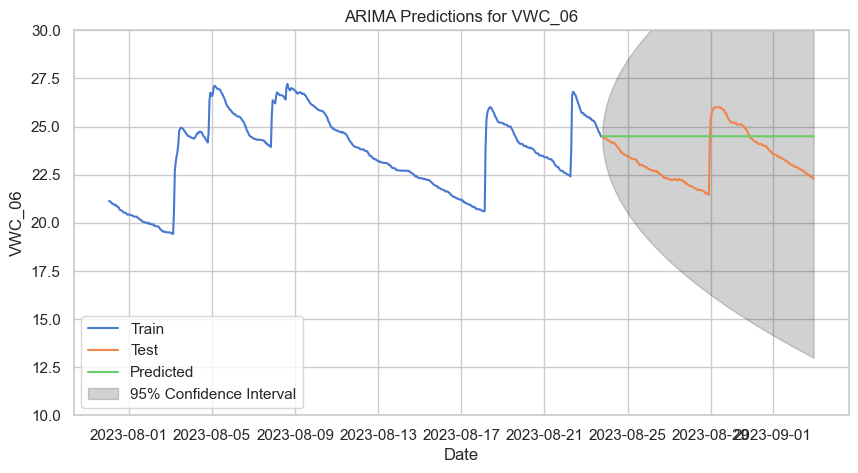

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1126.697, Time=0.96 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1054.615, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1102.132, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1097.356, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1055.481, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1122.306, Time=0.64 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1120.744, Time=0.49 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1129.206, Time=1.29 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1121.311, Time=1.57 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-1123.993, Time=1.68 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-1124.958, Time=1.05 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1124.267, Time=2.16 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-1118.992, Time=1.57 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-1123.129, Time=2.58 sec
 ARIMA(3,1,2)(0,0,0

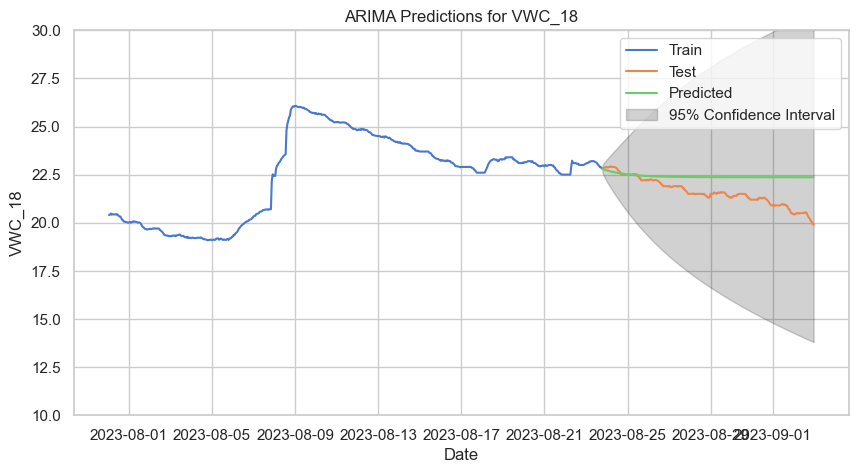

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-114.823, Time=1.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-81.619, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-89.861, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-92.716, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-83.592, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-95.231, Time=0.43 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-96.063, Time=0.45 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-112.797, Time=1.89 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-114.091, Time=2.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-103.665, Time=0.63 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-93.235, Time=1.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-94.350, Time=0.61 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.18 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-117.456, Time=1.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-97.

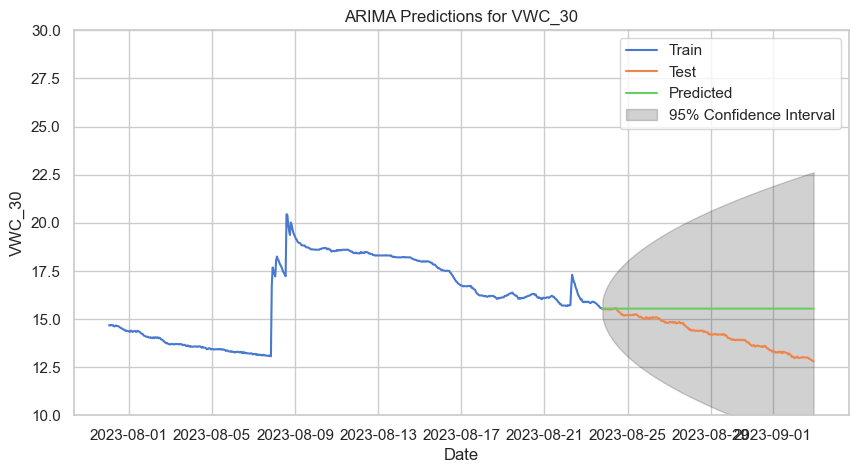

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2358.720, Time=1.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2359.652, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2363.276, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2363.765, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2341.447, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2362.717, Time=0.80 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2362.596, Time=0.38 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2360.483, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2341.556, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 3.951 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  570
Model:               SARIMAX(0, 1, 1)   Log Likelihood                1184.883
Date:                Mon, 12 Feb 2024   

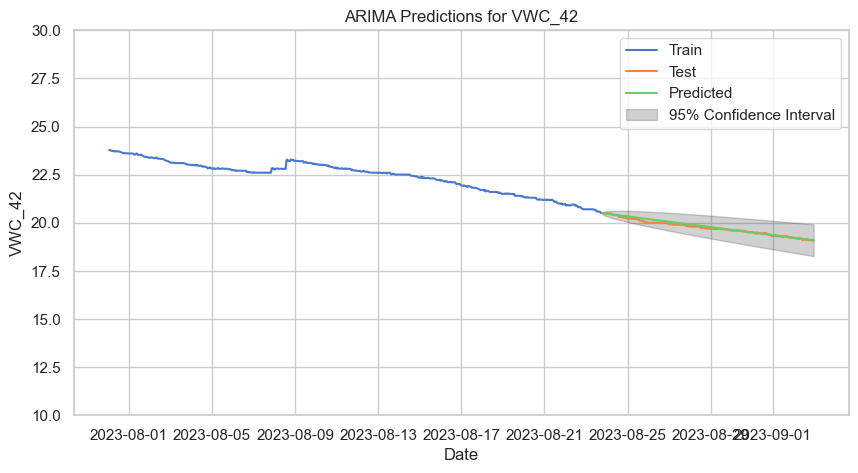

In [111]:
import pandas as pd
from pmdarima.arima import auto_arima
from sklearn.model_selection import train_test_split

# Prepare data for auto_arima (including exogenous variables)
df_exog = df[exog_columns]  

for target_col in target_columns:
    df_target = df[target_col]  # Target variable

    # 80/20 Train-Test Split
    train_size = 0.7
    train_index = int(train_size * len(df_target))

    X_train, X_test = df_target[:train_index], df_target[train_index:]
    exog_train, exog_test = df_exog[:train_index], df_exog[train_index:]

    # Fit auto_arima on training data
    model = auto_arima(X_train, exogenous=exog_train, stepwise=True, trace=True)
    print(model.summary())

    # Predictions on the test set
    predictions, conf_int = model.predict(n_periods=len(X_test), 
                                          exogenous=exog_test,
                                          return_conf_int=True)

    # Plotting
    import matplotlib.pyplot as plt 
    plt.figure(figsize=(10, 5)) 

    plt.plot(X_train, label='Train') # Plot the training data
    plt.plot(X_test, label='Test') # Plot the original test data
    plt.plot(predictions, label='Predicted')
    plt.fill_between(predictions.index, conf_int[:, 0], conf_int[:, 1],
                     color='k', alpha=.2, label='95% Confidence Interval')

    plt.title(f'ARIMA Predictions for {target_col}')
    plt.xlabel('Date')
    plt.ylabel(target_col)
    plt.legend()
    plt.ylim(10, 30) 
    plt.show()


In [120]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import numpy as np

# Assuming 'df' is your DataFrame containing all the data, and it's sorted by time

# Determine the split index instead of random splitting
split_ratio = 0.8
split_index = int(len(df) * split_ratio)

# Split dataset into features (X) and target (y) maintaining temporal order
X_train = df.iloc[:split_index][training_variables]
X_val = df.iloc[split_index:][training_variables]
y_train = df.iloc[:split_index][target_columns]
y_val = df.iloc[split_index:][target_columns]

models = {}
val_rmses = []

for target in target_columns:
    print(f"Training model for {target}")
    model = XGBRegressor(
        max_depth=8,
        learning_rate=0.4,
        subsample=1,
        colsample_bytree=1,
        reg_lambda=0.1,
        reg_alpha=0.1,
        gamma=0.1,
        n_estimators=1000,
        verbosity=1,
        objective='reg:squarederror'
    )
    
    # Fit the model
    model.fit(X_train, y_train[target],
              eval_set=[(X_val, y_val[target])],
              early_stopping_rounds=50,
              verbose=True)
    
    # Save the model for each target
    models[target] = model
    
    # Predict and evaluate
    y_val_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val[target], y_val_pred))
    val_rmses.append((target, rmse))
    print(f"Validation RMSE for {target}: {rmse:.2f}")

# Output RMSE for each target variable
for target, rmse in val_rmses:
    print(f"{target}: RMSE = {rmse:.2f}")


Training model for VWC_06
[0]	validation_0-rmse:14.14258
[1]	validation_0-rmse:9.28707


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:6.18318
[3]	validation_0-rmse:4.40987
[4]	validation_0-rmse:3.44170
[5]	validation_0-rmse:2.85282
[6]	validation_0-rmse:2.51743
[7]	validation_0-rmse:2.29498
[8]	validation_0-rmse:2.17812
[9]	validation_0-rmse:2.08890
[10]	validation_0-rmse:2.04503
[11]	validation_0-rmse:2.01216
[12]	validation_0-rmse:1.99373
[13]	validation_0-rmse:1.98647
[14]	validation_0-rmse:1.97968
[15]	validation_0-rmse:1.97561
[16]	validation_0-rmse:1.97317
[17]	validation_0-rmse:1.97171
[18]	validation_0-rmse:1.97083
[19]	validation_0-rmse:1.97030
[20]	validation_0-rmse:1.96999
[21]	validation_0-rmse:1.96980
[22]	validation_0-rmse:1.96968
[23]	validation_0-rmse:1.96961
[24]	validation_0-rmse:1.96957
[25]	validation_0-rmse:1.96955
[26]	validation_0-rmse:1.96953
[27]	validation_0-rmse:1.96953
[28]	validation_0-rmse:1.96952
[29]	validation_0-rmse:1.96952
[30]	validation_0-rmse:1.96952
[31]	validation_0-rmse:1.96952
[32]	validation_0-rmse:1.96951
[33]	validation_0-rmse:1.96951
[34]	validation_

c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[31]	validation_0-rmse:0.85626
[32]	validation_0-rmse:0.85626
[33]	validation_0-rmse:0.85626
[34]	validation_0-rmse:0.85626
[35]	validation_0-rmse:0.85626
[36]	validation_0-rmse:0.85626
[37]	validation_0-rmse:0.85626
[38]	validation_0-rmse:0.85626
[39]	validation_0-rmse:0.85626
[40]	validation_0-rmse:0.85626
[41]	validation_0-rmse:0.85626
[42]	validation_0-rmse:0.85626
[43]	validation_0-rmse:0.85626
[44]	validation_0-rmse:0.85626
[45]	validation_0-rmse:0.85626
[46]	validation_0-rmse:0.85626
[47]	validation_0-rmse:0.85626
[48]	validation_0-rmse:0.85626
[49]	validation_0-rmse:0.85626
[50]	validation_0-rmse:0.85626
[51]	validation_0-rmse:0.85626
[52]	validation_0-rmse:0.85626
[53]	validation_0-rmse:0.85626
[54]	validation_0-rmse:0.85626
Validation RMSE for VWC_18: 0.44
Training model for VWC_30
[0]	validation_0-rmse:7.47757
[1]	validation_0-rmse:3.96437
[2]	validation_0-rmse:1.95280
[3]	validation_0-rmse:0.84240
[4]	validation_0-rmse:0.57381
[5]	validation_0-rmse:0.76187
[6]	validation_0-

c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[32]	validation_0-rmse:1.28270
[33]	validation_0-rmse:1.28270
[34]	validation_0-rmse:1.28270
[35]	validation_0-rmse:1.28270
[36]	validation_0-rmse:1.28270
[37]	validation_0-rmse:1.28270
[38]	validation_0-rmse:1.28270
[39]	validation_0-rmse:1.28270
[40]	validation_0-rmse:1.28270
[41]	validation_0-rmse:1.28270
[42]	validation_0-rmse:1.28270
[43]	validation_0-rmse:1.28270
[44]	validation_0-rmse:1.28270
[45]	validation_0-rmse:1.28270
[46]	validation_0-rmse:1.28270
[47]	validation_0-rmse:1.28270
[48]	validation_0-rmse:1.28270
[49]	validation_0-rmse:1.28270
[50]	validation_0-rmse:1.28270
[51]	validation_0-rmse:1.28270
[52]	validation_0-rmse:1.28270
[53]	validation_0-rmse:1.28270
Validation RMSE for VWC_30: 0.57
Training model for VWC_42
[0]	validation_0-rmse:11.12894
[1]	validation_0-rmse:6.37347
[2]	validation_0-rmse:3.62255
[3]	validation_0-rmse:1.92558
[4]	validation_0-rmse:0.95546
[5]	validation_0-rmse:0.44715
[6]	validation_0-rmse:0.24542
[7]	validation_0-rmse:0.32010
[8]	validation_0-r

c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[24]	validation_0-rmse:0.60779
[25]	validation_0-rmse:0.60781
[26]	validation_0-rmse:0.60782
[27]	validation_0-rmse:0.60783
[28]	validation_0-rmse:0.60784
[29]	validation_0-rmse:0.60784
[30]	validation_0-rmse:0.60784
[31]	validation_0-rmse:0.60784
[32]	validation_0-rmse:0.60784
[33]	validation_0-rmse:0.60784
[34]	validation_0-rmse:0.60784
[35]	validation_0-rmse:0.60784
[36]	validation_0-rmse:0.60784
[37]	validation_0-rmse:0.60784
[38]	validation_0-rmse:0.60784
[39]	validation_0-rmse:0.60784
[40]	validation_0-rmse:0.60784
[41]	validation_0-rmse:0.60784
[42]	validation_0-rmse:0.60784
[43]	validation_0-rmse:0.60784
[44]	validation_0-rmse:0.60784
[45]	validation_0-rmse:0.60784
[46]	validation_0-rmse:0.60784
[47]	validation_0-rmse:0.60784
[48]	validation_0-rmse:0.60784
[49]	validation_0-rmse:0.60784
[50]	validation_0-rmse:0.60784
[51]	validation_0-rmse:0.60784
[52]	validation_0-rmse:0.60784
[53]	validation_0-rmse:0.60784
[54]	validation_0-rmse:0.60784
[55]	validation_0-rmse:0.60784
[56]	val

Epoch 1/30
49/49 [==============================] - 2s 40ms/step - loss: nan
Epoch 2/30
49/49 [==============================] - 2s 43ms/step - loss: nan
Epoch 3/30
49/49 [==============================] - 2s 40ms/step - loss: nan
Epoch 4/30
49/49 [==============================] - 2s 44ms/step - loss: nan
Epoch 5/30
1/1 [==============================] - 0s 70ms/step


C:\Users\bnsoh2\AppData\Local\Temp\ipykernel_18732\2147891189.py:85: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



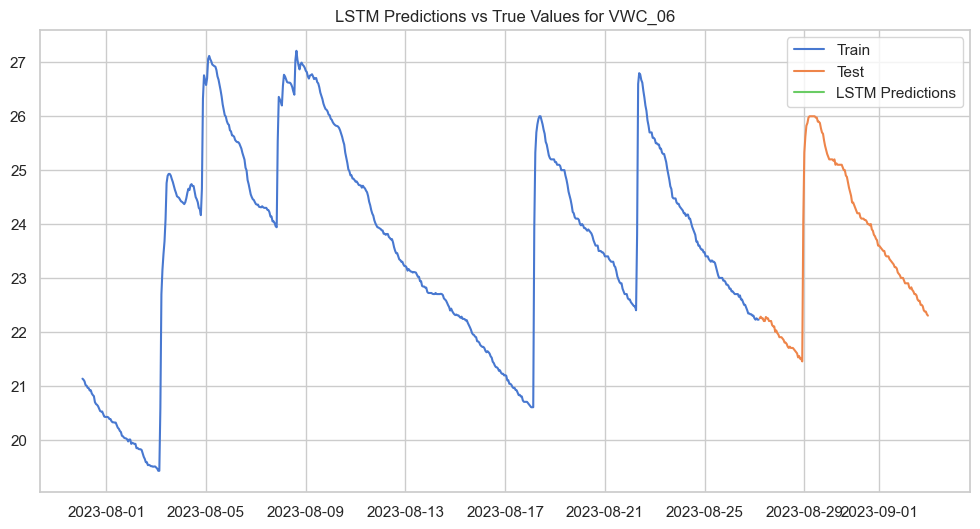

Epoch 1/30
49/49 [==============================] - 3s 61ms/step - loss: nan
Epoch 2/30
49/49 [==============================] - 2s 45ms/step - loss: nan
Epoch 3/30
49/49 [==============================] - 2s 47ms/step - loss: nan
Epoch 4/30
49/49 [==============================] - 2s 45ms/step - loss: nan
Epoch 5/30
1/1 [==============================] - 0s 71ms/step


C:\Users\bnsoh2\AppData\Local\Temp\ipykernel_18732\2147891189.py:85: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



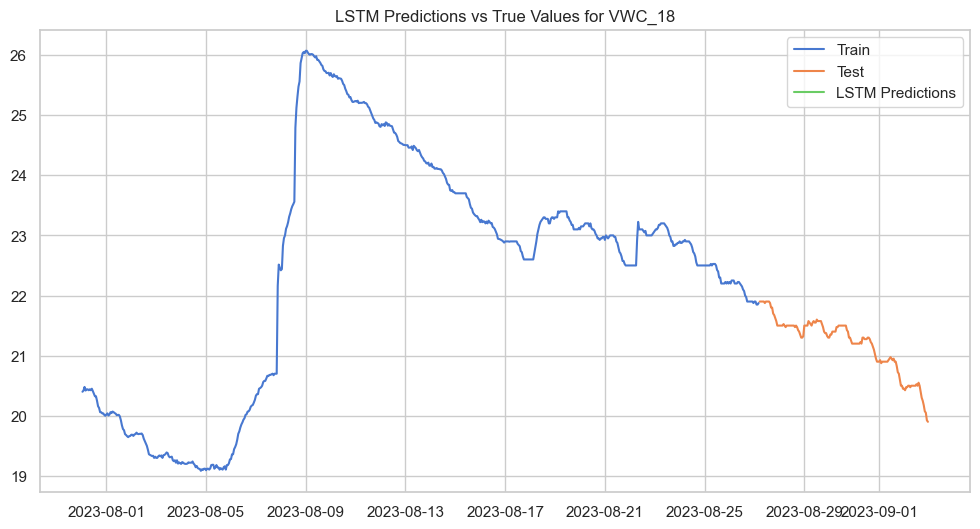

Epoch 1/30
49/49 [==============================] - 4s 84ms/step - loss: nan
Epoch 2/30
49/49 [==============================] - 4s 76ms/step - loss: nan
Epoch 3/30
49/49 [==============================] - 4s 84ms/step - loss: nan
Epoch 4/30
49/49 [==============================] - 4s 76ms/step - loss: nan
Epoch 5/30
1/1 [==============================] - 0s 41ms/step


C:\Users\bnsoh2\AppData\Local\Temp\ipykernel_18732\2147891189.py:85: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



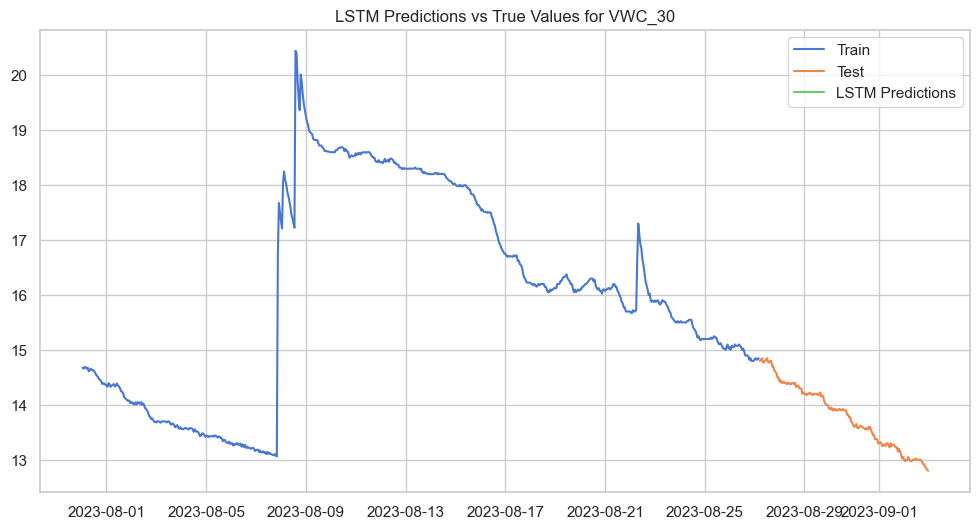

Epoch 1/30
49/49 [==============================] - 2s 43ms/step - loss: nan
Epoch 2/30
49/49 [==============================] - 2s 45ms/step - loss: nan
Epoch 3/30
49/49 [==============================] - 2s 41ms/step - loss: nan
Epoch 4/30
49/49 [==============================] - 2s 44ms/step - loss: nan
Epoch 5/30
1/1 [==============================] - 0s 33ms/step


C:\Users\bnsoh2\AppData\Local\Temp\ipykernel_18732\2147891189.py:85: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



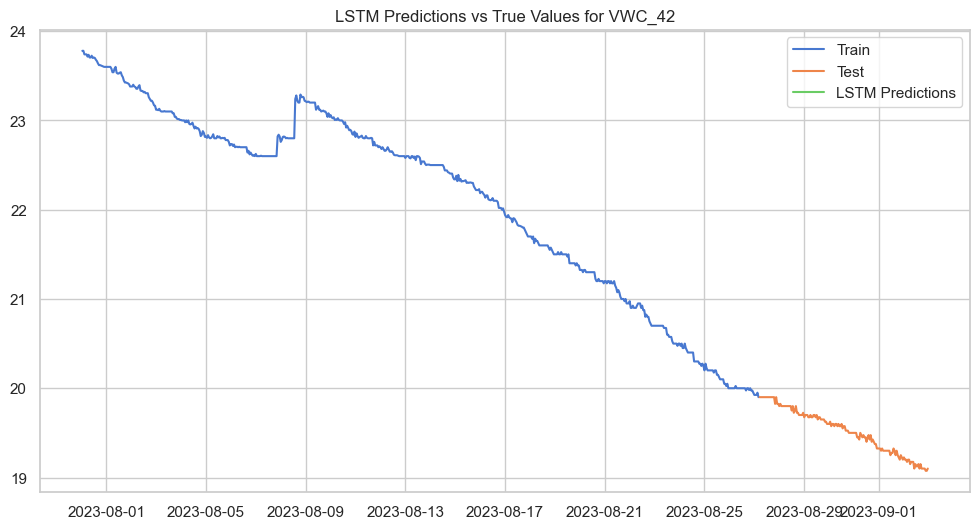

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf

# Assuming df is your DataFrame and contains all necessary columns
# Define time and correlation columns
time_columns = ['day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']
corr_columns = [
    'Ta_2m_Avg', 'RH_2m_Avg', 'Solar_2m_Avg', 'WndAveSpd_3m', 'Rain_1m_Tot',
    'Dp_2m_Avg', 'TaMax_2m', 'TaMin_2m', 'RHMax_2m', 'RHMin_2m', 'HeatIndex_2m_Avg', 'canopy_temp', 'VWC_06', 'VWC_18',
    'VWC_30', 'VWC_42', 'plot_number', 'daily_et', 'CWSI', 'SWSI', 'irrigation', 'precip_irrig'
]
target_columns = ['VWC_06', 'VWC_18', 'VWC_30', 'VWC_42']

# Splitting the dataset into training and test while maintaining time order
split_idx = int(len(df) * 0.8)
train_df = df[:split_idx]
test_df = df[split_idx:]



# Scaling
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[time_columns + corr_columns])
test_scaled = scaler.transform(test_df[time_columns + corr_columns])

# Define n_input, n_features for the generator
n_input = 168  # Use a week's data to predict
n_features = len(time_columns + corr_columns)  # Number of features

with tf.device('/GPU:0'):  # Explicitly place operations on your GPU
    # Creating separate models for each target variable
    for target in target_columns:
        # Prepare target data for scaling
        target_scaler = MinMaxScaler()
        train_target_scaled = target_scaler.fit_transform(train_df[[target]])
        test_target_scaled = target_scaler.transform(test_df[[target]])
        
        # Create the TimeseriesGenerator for training data
        generator = TimeseriesGenerator(train_scaled, train_target_scaled, length=n_input, batch_size=10)
        

        # Fit model with early stopping monitoring 'loss' instead of 'val_loss'
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)


        # Fit model
        model.fit(generator, epochs=30, shuffle=False, callbacks=[early_stopping])
        
        # Predictions
        test_predictions = []
        first_eval_batch = train_scaled[-n_input:]
        current_batch = first_eval_batch.reshape((1, n_input, n_features))
        
        for _ in range(len(test_df)):
            current_pred = model.predict(current_batch)[0]
            test_predictions.append(current_pred)
            # Assuming current_pred is the output from the model and needs to be inserted as a new value for a specific feature
            
            #******************************************************
            # Let's say index 0 (the first feature) is the one we're updating with the prediction

            # Corrected feature update assuming current_pred is aligned with the target feature index
            feature_index_to_update = 0  # Adjust this index to match the target feature your model predicts

            # Step 1: Copy the last time step
            new_time_step = current_batch[:, -1, :].copy()

            # Step 2: Update the specific feature with the new prediction
            new_time_step[feature_index_to_update] = current_pred

            # Step 3: Append this updated time step to the batch, removing the oldest time step
            current_batch = np.append(current_batch[:, 1:, :], np.expand_dims(new_time_step, axis=0), axis=1)


            #*************************************

        
        # Inverse transform predictions
        true_predictions = target_scaler.inverse_transform(test_predictions)
        test_df[f'{target}_LSTM_Predictions'] = true_predictions
        
        # Plot predictions
        plt.figure(figsize=(12, 6))
        plt.plot(train_df[target], label='Train')
        plt.plot(test_df[target], label='Test')
        plt.plot(test_df.index, true_predictions, label='LSTM Predictions')
        plt.title(f'LSTM Predictions vs True Values for {target}')
        plt.legend()
        plt.show()

# Note: Adjust the plotting and evaluation code according to your specific DataFrame structure and indexing.
